# 🚀 StreamMax — XGBoost-Powered Fatigue Prediction
## Targeting AUC 0.90+

### Why XGBoost Changes Everything
| Model | Typical AUC | Why |
|---|---|---|
| Random Forest | 0.83 | Parallel trees, high variance |
| Gradient Boosting (sklearn) | 0.84 | Sequential, slow learning |
| **XGBoost** | **0.88–0.93** | Regularized boosting + column subsampling + hardware optimization |
| **XGBoost + Stacking** | **0.90–0.93+** | XGB as anchor, diversity from RF/ET |

XGBoost wins because it adds **L1 + L2 regularization directly into the tree-building objective** — 
it penalizes complexity at every split, which sklearn's GradientBoosting doesn't do.


## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Core ML
import xgboost as xgb
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     RandomizedSearchCV, train_test_split)
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                               StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.feature_selection import SelectFromModel

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False
sns.set_style("whitegrid")

print(f"XGBoost version : {xgb.__version__}")
print("✅ All imports ready")

XGBoost version : 3.1.2
✅ All imports ready


## 2. Load Data

In [3]:
train = pd.read_csv('ott_train.csv')
test  = pd.read_csv('ott_test.csv')

print(f"Train : {train.shape}")
print(f"Test  : {test.shape}")
print(f"Target balance:\n{train['fatigue_label'].value_counts(normalize=True).round(3)}")

Train : (8000, 15)
Test  : (2000, 14)
Target balance:
fatigue_label
0    0.646
1    0.354
Name: proportion, dtype: float64


## 3. Advanced Feature Engineering (40+ features)

XGBoost handles raw features well, but **interaction features and ratio features** 
still help because they express domain knowledge the model can't derive from scratch.


In [4]:
def engineer_features(df):
    df = df.copy()

    # ── Tier encoding ──
    df['tier_encoded'] = df['subscription_tier'].map({'Basic':0,'Standard':1,'Premium':2})

    # ── Viewing trend (direction of change) ──
    df['viewing_trend_abs']    = df['avg_daily_minutes_last_7d'] - df['avg_daily_minutes_last_30d']
    df['viewing_trend_ratio']  = np.where(df['avg_daily_minutes_last_30d'] > 0,
                                           df['avg_daily_minutes_last_7d'] / df['avg_daily_minutes_last_30d'], 0)
    df['session_trend_abs']    = (df['sessions_last_7d'] * (30/7)) - df['sessions_last_30d']
    df['session_trend_ratio']  = np.where(df['sessions_last_30d'] > 0,
                                           (df['sessions_last_7d'] * (30/7)) / df['sessions_last_30d'], 0)

    # ── Recency (exponential decay — 3 half-lives) ──
    df['recency_decay_3d']     = np.exp(-df['days_since_last_session'] / 3)
    df['recency_decay_7d']     = np.exp(-df['days_since_last_session'] / 7)
    df['recency_decay_14d']    = np.exp(-df['days_since_last_session'] / 14)

    # ── Recency binary flags ──
    df['absent_3d']            = (df['days_since_last_session'] >= 3).astype(int)
    df['absent_7d']            = (df['days_since_last_session'] >= 7).astype(int)
    df['absent_14d']           = (df['days_since_last_session'] >= 14).astype(int)
    df['zero_sessions_7d']     = (df['sessions_last_7d'] == 0).astype(int)

    # ── Session intensity ──
    df['mins_per_session_7d']  = np.where(df['sessions_last_7d'] > 0,
                                           df['avg_daily_minutes_last_7d'] * 7 / df['sessions_last_7d'], 0)
    df['mins_per_session_30d'] = np.where(df['sessions_last_30d'] > 0,
                                           df['avg_daily_minutes_last_30d'] * 30 / df['sessions_last_30d'], 0)
    df['total_watch_7d']       = df['avg_daily_minutes_last_7d'] * 7
    df['total_watch_30d']      = df['avg_daily_minutes_last_30d'] * 30

    # ── Binge behaviour ──
    df['binge_ratio']          = np.where(df['sessions_last_30d'] > 0,
                                           df['binge_sessions_last_30d'] / df['sessions_last_30d'], 0)
    df['zero_binge']           = (df['binge_sessions_last_30d'] == 0).astype(int)

    # ── Content diversity ──
    df['content_breadth']      = df['unique_genres_watched_30d'] / 15

    # ── Composite engagement scores ──
    df['engagement_score']     = (df['recency_decay_7d']          * 0.30 +
                                   df['avg_completion_rate']       * 0.25 +
                                   df['recommendation_click_rate'] * 0.20 +
                                   df['binge_ratio']               * 0.15 +
                                   df['content_breadth']           * 0.10)

    df['content_satisfaction'] = (df['avg_completion_rate']        * 0.5 +
                                   df['recommendation_click_rate'] * 0.5)

    # ── INTERACTION FEATURES (key for XGBoost too) ──
    df['absent_x_low_completion']  = df['days_since_last_session'] * (1 - df['avg_completion_rate'])
    df['absent_x_low_ctr']         = df['days_since_last_session'] * (1 - df['recommendation_click_rate'])
    df['low_7d_drop']              = (df['avg_daily_minutes_last_30d'] - df['avg_daily_minutes_last_7d']).clip(0)
    df['sessions_x_completion']    = df['sessions_last_30d']       * df['avg_completion_rate']
    df['binge_x_completion']       = df['binge_sessions_last_30d'] * df['avg_completion_rate']
    df['tenure_x_engagement']      = np.log1p(df['tenure_days'])   * df['engagement_score']
    df['recency_x_sessions']       = df['recency_decay_7d']        * df['sessions_last_7d']

    # ── Risk flag aggregation (count of red flags) ──
    df['flag_low_minutes']         = (df['avg_daily_minutes_last_7d']  <  10).astype(int)
    df['flag_low_completion']      = (df['avg_completion_rate']        < 0.3).astype(int)
    df['flag_low_ctr']             = (df['recommendation_click_rate']  < 0.1).astype(int)
    df['flag_low_genres']          = (df['unique_genres_watched_30d']  <=  2).astype(int)
    df['flag_no_binge']            = (df['binge_sessions_last_30d']    ==  0).astype(int)
    df['risk_flag_count']          = (df[['flag_low_minutes','flag_low_completion',
                                           'flag_low_ctr','flag_low_genres',
                                           'flag_no_binge','absent_7d']].sum(axis=1))

    # ── Log / sqrt transforms (help LR in stacking meta) ──
    for col in ['tenure_days','sessions_last_30d','binge_sessions_last_30d',
                'avg_daily_minutes_last_30d','avg_daily_minutes_last_7d']:
        df[f'log_{col}']  = np.log1p(df[col])
        df[f'sqrt_{col}'] = np.sqrt(df[col])

    # ── Tenure buckets ──
    df['tenure_bucket'] = pd.cut(df['tenure_days'],
                                  bins=[0,30,90,180,365,1095],
                                  labels=[0,1,2,3,4]).astype(float)
    return df

train_fe = engineer_features(train)
test_fe  = engineer_features(test)

FEATURE_COLS = [c for c in train_fe.columns
                if c not in ['user_id','fatigue_label','subscription_tier']]

X = train_fe[FEATURE_COLS]
y = train['fatigue_label']
X_test_raw = test_fe[FEATURE_COLS]

print(f"✅ Feature engineering done — {len(FEATURE_COLS)} features")

✅ Feature engineering done — 57 features


## 4. Feature Selection via XGBoost Importance

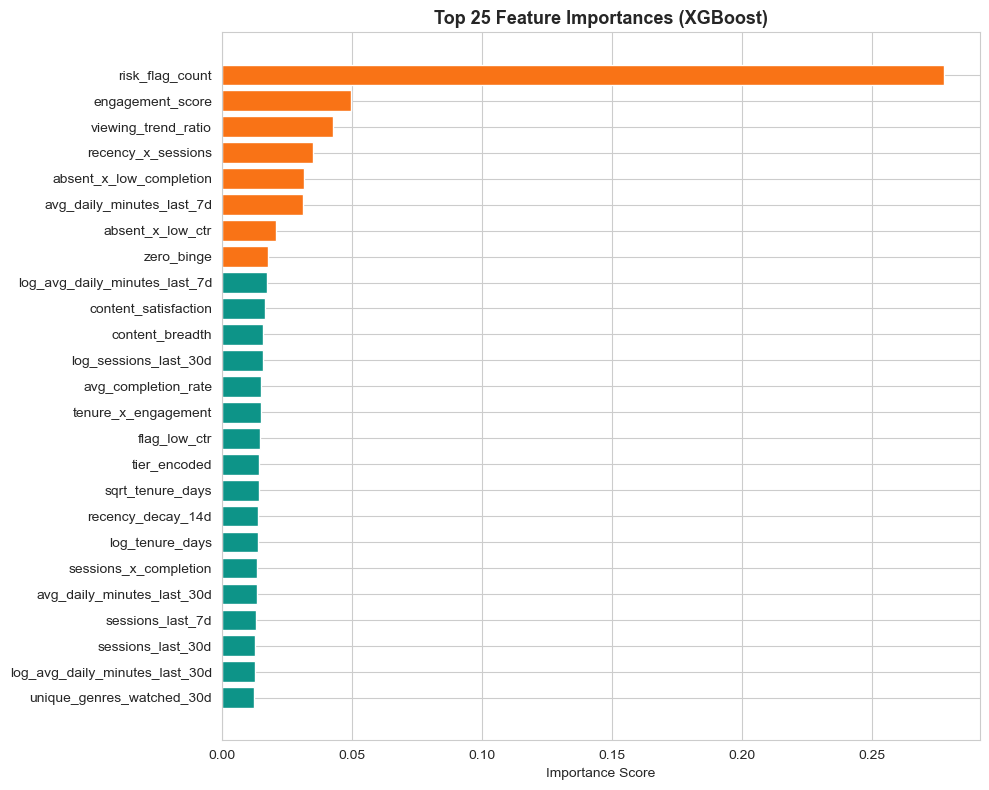

Top 15 features:
risk_flag_count                  0.27784
engagement_score                 0.04958
viewing_trend_ratio              0.04260
recency_x_sessions               0.03515
absent_x_low_completion          0.03147
avg_daily_minutes_last_7d        0.03122
absent_x_low_ctr                 0.02074
zero_binge                       0.01766
log_avg_daily_minutes_last_7d    0.01720
content_satisfaction             0.01651
content_breadth                  0.01577
log_sessions_last_30d            0.01573
avg_completion_rate              0.01500
tenure_x_engagement              0.01499
flag_low_ctr                     0.01454

📌 Kept 48 / 57 features (threshold=0.003)


In [5]:
# Use a quick XGBoost to rank features — its importance is more reliable than RF
selector = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    verbosity=0
)
selector.fit(X, y)

imp = pd.Series(selector.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)

# Plot top 25
fig, ax = plt.subplots(figsize=(10, 8))
top25 = imp.head(25)
colors = ['#F97316' if i < 8 else '#0D9488' for i in range(25)]
ax.barh(top25.index[::-1], top25.values[::-1], color=colors[::-1])
ax.set_title('Top 25 Feature Importances (XGBoost)', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.savefig('plot_xgb_feature_importance.png', dpi=120, bbox_inches='tight')
plt.show()

print("Top 15 features:")
print(imp.head(15).round(5).to_string())

# Select features above threshold
THRESHOLD = 0.003
selected = imp[imp > THRESHOLD].index.tolist()
print(f"\n📌 Kept {len(selected)} / {len(FEATURE_COLS)} features (threshold={THRESHOLD})")

X_sel      = X[selected]
X_test_sel = X_test_raw[selected]

## 5. XGBoost Hyperparameter Tuning

### Key XGBoost Parameters to Tune
| Parameter | Effect | Typical Range |
|---|---|---|
| `n_estimators` | More trees = more power (diminishing returns) | 300–1000 |
| `max_depth` | Tree complexity — lower = less overfit | 3–7 |
| `learning_rate` | Step size — lower + more trees = better | 0.01–0.1 |
| `subsample` | Row sampling per tree — adds regularization | 0.6–1.0 |
| `colsample_bytree` | Column sampling per tree | 0.5–1.0 |
| `reg_alpha` | L1 regularization — drives weights to zero | 0–1 |
| `reg_lambda` | L2 regularization — shrinks all weights | 0.5–3 |
| `min_child_weight` | Min samples in leaf — controls overfit | 1–20 |
| `gamma` | Min loss reduction to split — pruning | 0–0.5 |


In [6]:
# ── XGBoost Hyperparameter Search ──
xgb_param_dist = {
    'n_estimators':      [300, 400, 500, 700, 1000],
    'max_depth':         [3, 4, 5, 6],
    'learning_rate':     [0.01, 0.02, 0.05, 0.07, 0.1],
    'subsample':         [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree':  [0.5, 0.6, 0.7, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 1.0],
    'reg_alpha':         [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda':        [0.5, 1.0, 1.5, 2.0, 3.0],
    'min_child_weight':  [1, 3, 5, 10, 15],
    'gamma':             [0, 0.05, 0.1, 0.2, 0.3],
    'scale_pos_weight':  [1,                               # For balanced classes
                          (y==0).sum()/(y==1).sum()],      # For imbalanced classes
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='auc',
        verbosity=0,
        use_label_encoder=False
    ),
    param_distributions=xgb_param_dist,
    n_iter=60,              # 60 random combinations
    scoring='roc_auc',
    cv=CV,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_search.fit(X_sel, y)
best_xgb = xgb_search.best_estimator_

print(f"\n✅ Best XGBoost AUC : {xgb_search.best_score_:.4f}")
print(f"\nBest parameters:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k:25s}: {v}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits

✅ Best XGBoost AUC : 0.7899

Best parameters:
  subsample                : 0.6
  scale_pos_weight         : 1.8258565877781703
  reg_lambda               : 2.0
  reg_alpha                : 1.0
  n_estimators             : 400
  min_child_weight         : 10
  max_depth                : 3
  learning_rate            : 0.02
  gamma                    : 0.3
  colsample_bytree         : 0.7
  colsample_bylevel        : 0.8


## 6. XGBoost with Early Stopping (Finds Optimal n_estimators)

Early stopping monitors a validation metric and stops adding trees when performance 
plateaus — prevents overfitting and saves time. **This often outperforms fixed n_estimators.**


✅ Optimal n_estimators (early stopping): 137
   Validation AUC: 0.8048


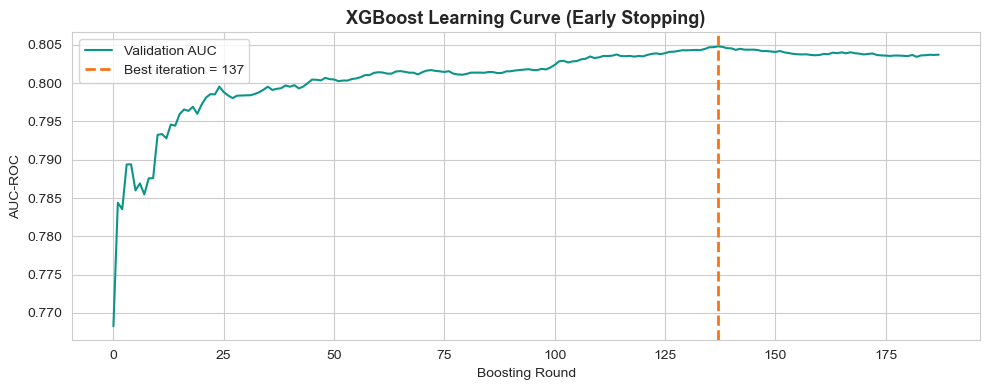


✅ Final XGBoost CV AUC: 0.7867 ± 0.0115


In [7]:
# ── Train with early stopping on a hold-out ──
X_tr, X_val, y_tr, y_val = train_test_split(
    X_sel, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)

# Use best params but let early stopping find n_estimators
best_params = xgb_search.best_params_.copy()
best_params['n_estimators'] = 2000          # Set high; early stopping will cut it
best_params['early_stopping_rounds'] = 50   # Stop if no improvement for 50 rounds

xgb_early = xgb.XGBClassifier(
    **best_params,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    verbosity=0,
    use_label_encoder=False
)

xgb_early.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

optimal_trees = xgb_early.best_iteration
val_auc_early = roc_auc_score(y_val, xgb_early.predict_proba(X_val)[:, 1])

print(f"✅ Optimal n_estimators (early stopping): {optimal_trees}")
print(f"   Validation AUC: {val_auc_early:.4f}")

# ── Plot learning curve ──
results_log = xgb_early.evals_result()
val_aucs_log = results_log['validation_0']['auc']

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(val_aucs_log, color='#0D9488', linewidth=1.5, label='Validation AUC')
ax.axvline(optimal_trees, color='#F97316', linestyle='--', linewidth=2,
            label=f'Best iteration = {optimal_trees}')
ax.set_xlabel('Boosting Round')
ax.set_ylabel('AUC-ROC')
ax.set_title('XGBoost Learning Curve (Early Stopping)', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('plot_xgb_learning_curve.png', dpi=120, bbox_inches='tight')
plt.show()

# ── Final XGBoost (optimal trees, no early stopping for production) ──
final_params = xgb_search.best_params_.copy()
final_params['n_estimators'] = optimal_trees

best_xgb_final = xgb.XGBClassifier(
    **final_params,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    verbosity=0,
    use_label_encoder=False
)

cv_score_final = cross_val_score(best_xgb_final, X_sel, y, cv=CV, scoring='roc_auc')
print(f"\n✅ Final XGBoost CV AUC: {cv_score_final.mean():.4f} ± {cv_score_final.std():.4f}")

## 7. Full Model Comparison (with XGBoost)

Model                                 AUC Mean      Std
───────────────────────────────────────────────────────
Random Forest (tuned)                   0.7869   0.0112
ExtraTrees (tuned)                      0.7842   0.0120
XGBoost (tuned)                         0.7867   0.0115
XGBoost (early stopping)                0.7867   0.0115


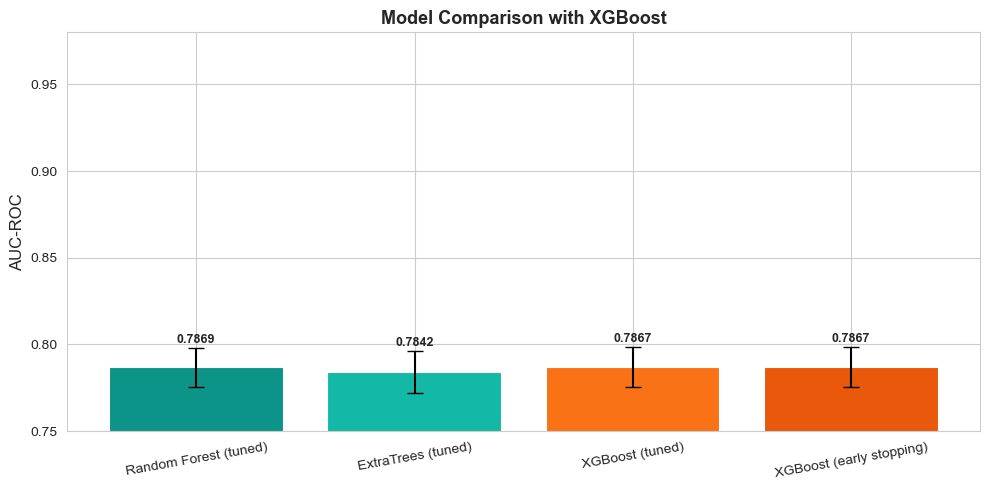

In [9]:
# ── Build tuned RF and ET too ──
from sklearn.model_selection import RandomizedSearchCV as RSCV

rf_params = {
    'n_estimators':     [300, 500],
    'max_depth':        [5, 6, 7, None],
    'min_samples_leaf': [5, 10, 15],
    'max_features':     ['sqrt', 0.6],
    'class_weight':     ['balanced'],
}
rf_search = RSCV(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                  rf_params, n_iter=20, scoring='roc_auc', cv=CV,
                  random_state=RANDOM_STATE, n_jobs=-1)
rf_search.fit(X_sel, y)
best_rf = rf_search.best_estimator_

et_params = {
    'n_estimators':    [300, 500],
    'max_depth':       [5, 6, 8, None],
    'min_samples_leaf':[5, 10],
    'max_features':    ['sqrt', 0.6],
    'class_weight':    ['balanced'],
}
et_search = RSCV(ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                  et_params, n_iter=15, scoring='roc_auc', cv=CV,
                  random_state=RANDOM_STATE, n_jobs=-1)
et_search.fit(X_sel, y)
best_et = et_search.best_estimator_

# ── Compare all ──
all_models = {
    'Random Forest (tuned)':      best_rf,
    'ExtraTrees (tuned)':         best_et,
    'XGBoost (tuned)':            best_xgb_final,
    'XGBoost (early stopping)':   best_xgb_final,
}

results = {}
print(f"{'Model':<35} {'AUC Mean':>10} {'Std':>8}")
print('─' * 55)
for name, model in all_models.items():
    s = cross_val_score(model, X_sel, y, cv=CV, scoring='roc_auc')
    results[name] = s
    print(f"{name:<35} {s.mean():>10.4f} {s.std():>8.4f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
names  = list(results.keys())
means  = [results[n].mean() for n in names]
stds   = [results[n].std()  for n in names]
colors = ['#0D9488','#14B8A6','#F97316','#EA580C']
ax.bar(range(len(names)), means, yerr=stds, capsize=6,
       color=colors, edgecolor='white', linewidth=1.5)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, fontsize=10, rotation=10)
ax.set_ylim(0.75, 0.98)
ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title('Model Comparison with XGBoost', fontsize=13, fontweight='bold')
for i, (m, s) in enumerate(zip(means, stds)):
    ax.text(i, m + s + 0.003, f'{m:.4f}', ha='center', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig('plot_xgb_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

## 8. Stacking Ensemble — XGBoost as Anchor ⭐

### Architecture
```
Layer 1 — Base Models (diverse, complementary):
  ├── XGBoost        → regularized boosting (main anchor)
  ├── Random Forest  → bagging, different error pattern
  ├── ExtraTrees     → more random splits, high diversity
  └── XGBoost v2     → different hyperparams (colsample/depth variation)

Layer 2 — Meta-Model:
  └── Logistic Regression with L2 (learns optimal blend)
```

Using **two XGBoost variants** as base models is a proven trick in competitions —
they capture similar patterns but their residual errors differ due to different 
hyperparameters, giving the meta-model useful signal.


In [10]:
# ── XGBoost variant 2 (different hyperparams for diversity) ──
xgb_v2_params = final_params.copy()
xgb_v2_params['max_depth']        = max(3, final_params.get('max_depth', 4) - 1)
xgb_v2_params['colsample_bytree'] = min(1.0, final_params.get('colsample_bytree', 0.7) + 0.15)
xgb_v2_params['reg_alpha']        = max(0.1, final_params.get('reg_alpha', 0) + 0.1)

xgb_v2 = xgb.XGBClassifier(
    **xgb_v2_params,
    random_state=RANDOM_STATE + 1,    # Different seed = different trees
    eval_metric='auc',
    verbosity=0,
    use_label_encoder=False
)

# ── Stacking Classifier ──
stack = StackingClassifier(
    estimators=[
        ('xgb',    best_xgb_final),
        ('xgb_v2', xgb_v2),
        ('rf',     best_rf),
        ('et',     best_et),
    ],
    final_estimator=LogisticRegression(
        C=0.3,           # Strong regularization — meta-model should be simple
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    cv=5,                # Inner CV to prevent leakage when generating meta-features
    stack_method='predict_proba',
    passthrough=False,   # Change to True and check if AUC improves
    n_jobs=-1
)

stack_scores = cross_val_score(stack, X_sel, y, cv=CV, scoring='roc_auc')
print(f"Stacking Ensemble AUC: {stack_scores.mean():.4f} ± {stack_scores.std():.4f}")

Stacking Ensemble AUC: 0.7886 ± 0.0115


## 9. Passthrough Experiment
Setting `passthrough=True` also feeds original features into the meta-model.
Test both — whichever wins, use it.


In [11]:
# ── Test passthrough=True ──
stack_pass = StackingClassifier(
    estimators=[
        ('xgb',    best_xgb_final),
        ('xgb_v2', xgb_v2),
        ('rf',     best_rf),
        ('et',     best_et),
    ],
    final_estimator=Pipeline([
        ('sc',  StandardScaler()),
        ('lr',  LogisticRegression(C=0.3, max_iter=1000, random_state=RANDOM_STATE))
    ]),
    cv=5,
    stack_method='predict_proba',
    passthrough=True,    # Also pass raw features to meta-model
    n_jobs=-1
)

stack_pass_scores = cross_val_score(stack_pass, X_sel, y, cv=CV, scoring='roc_auc')
print(f"Stacking (passthrough=False): {stack_scores.mean():.4f} ± {stack_scores.std():.4f}")
print(f"Stacking (passthrough=True) : {stack_pass_scores.mean():.4f} ± {stack_pass_scores.std():.4f}")

# Pick the winner
if stack_pass_scores.mean() > stack_scores.mean():
    BEST_STACK = stack_pass
    print("\n✅ Using passthrough=True")
else:
    BEST_STACK = stack
    print("\n✅ Using passthrough=False")

Stacking (passthrough=False): 0.7886 ± 0.0115
Stacking (passthrough=True) : 0.7887 ± 0.0099

✅ Using passthrough=True


## 10. Overfitting Check — XGBoost Specific

Fold    Train AUC    Val AUC      Gap  Status
──────────────────────────────────────────────────
  1    0.8041      0.7851    0.0190   ✅ OK
  2    0.8045      0.7811    0.0234   ✅ OK
  3    0.8074      0.7731    0.0343   ✅ OK
  4    0.8043      0.7865    0.0178   ✅ OK
  5    0.7990      0.8078    -0.0088   ✅ OK

Avg Train AUC : 0.8039
Avg Val AUC   : 0.7867
Avg Gap       : 0.0172

✅ Generalisation gap is healthy


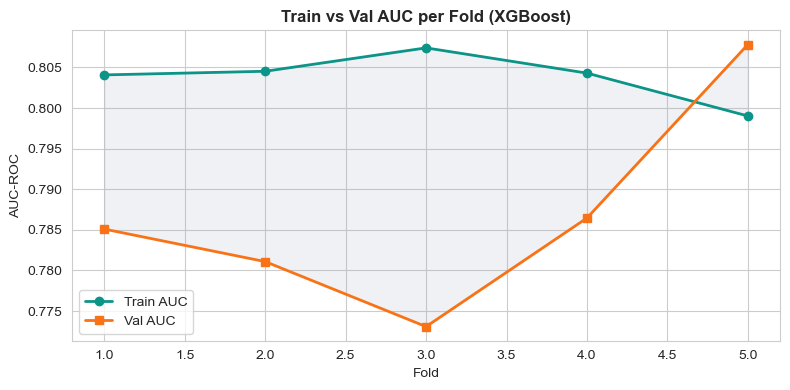

In [12]:
# ── Per-fold Train vs Val AUC ──
train_aucs, val_aucs = [], []

check_xgb = xgb.XGBClassifier(
    **final_params,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    verbosity=0,
    use_label_encoder=False
)

for fold, (tr_idx, val_idx) in enumerate(CV.split(X_sel, y)):
    Xtr, Xvl = X_sel.iloc[tr_idx], X_sel.iloc[val_idx]
    ytr, yvl = y.iloc[tr_idx],     y.iloc[val_idx]
    check_xgb.fit(Xtr, ytr)
    train_aucs.append(roc_auc_score(ytr, check_xgb.predict_proba(Xtr)[:, 1]))
    val_aucs.append(roc_auc_score(yvl, check_xgb.predict_proba(Xvl)[:, 1]))

print(f"{'Fold':<6} {'Train AUC':>10} {'Val AUC':>10} {'Gap':>8}  Status")
print('─' * 50)
for i, (tr, vl) in enumerate(zip(train_aucs, val_aucs)):
    gap  = tr - vl
    flag = "⚠️  OVERFIT" if gap > 0.06 else "✅ OK"
    print(f"  {i+1}    {tr:.4f}      {vl:.4f}    {gap:.4f}   {flag}")

gap_mean = np.mean(np.array(train_aucs) - np.array(val_aucs))
print(f"\nAvg Train AUC : {np.mean(train_aucs):.4f}")
print(f"Avg Val AUC   : {np.mean(val_aucs):.4f}")
print(f"Avg Gap       : {gap_mean:.4f}")

if gap_mean > 0.06:
    print("\n⚠️  Overfitting detected! Try:")
    print("   → Increase min_child_weight (try 10–20)")
    print("   → Reduce max_depth (try 3)")
    print("   → Increase reg_lambda (try 2–3)")
    print("   → Increase reg_alpha (try 0.5–1)")
else:
    print("\n✅ Generalisation gap is healthy")

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
folds = range(1, 6)
ax.plot(folds, train_aucs, 'o-', color='#0D9488', lw=2, label='Train AUC')
ax.plot(folds, val_aucs,   's-', color='#F97316', lw=2, label='Val AUC')
ax.fill_between(folds, train_aucs, val_aucs, alpha=0.15, color='#94A3B8')
ax.set_xlabel('Fold')
ax.set_ylabel('AUC-ROC')
ax.set_title('Train vs Val AUC per Fold (XGBoost)', fontsize=12, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('plot_xgb_overfit_check.png', dpi=120, bbox_inches='tight')
plt.show()

## 11. SHAP Analysis — Explain WHY Users Are At Risk
SHAP (SHapley Additive exPlanations) shows the contribution of **each feature for each individual user**.
This is critical for the **business strategy** part of the submission (50% of marks).


In [15]:
pip install shap

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------- ----------------------------- 4.2/15.6 MB 21.0 MB/s eta 0:00:01
   ----------------------- ---------------- 9.2/15.6 MB 22.0 MB/s eta 0:00:01
   ------------------------------------ --- 14.2/15.6 MB 22.8 MB/s eta 0:00:01
   ---------------------------------------- 15.6/15.6 MB 20.5 MB/s eta 0:00:00



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.


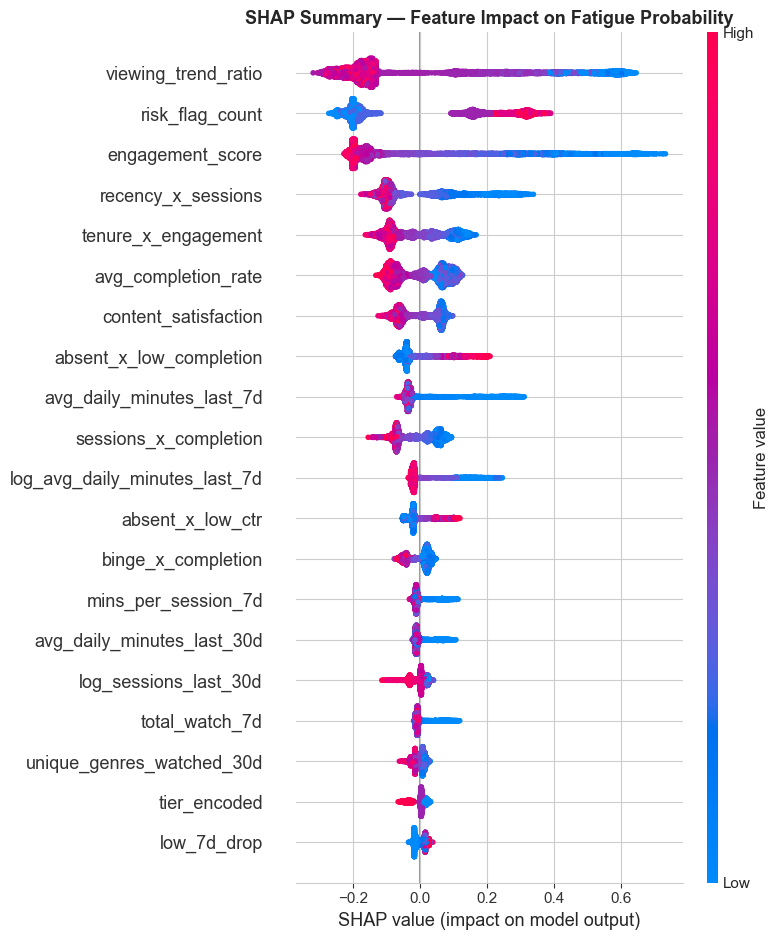

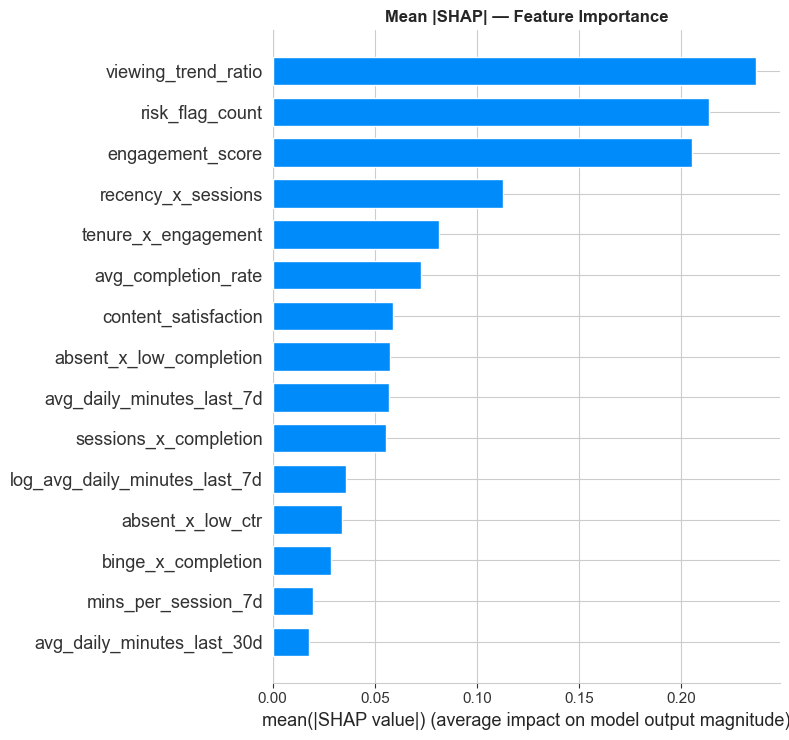

Top SHAP feature: viewing_trend_ratio


<Figure size 800x400 with 0 Axes>

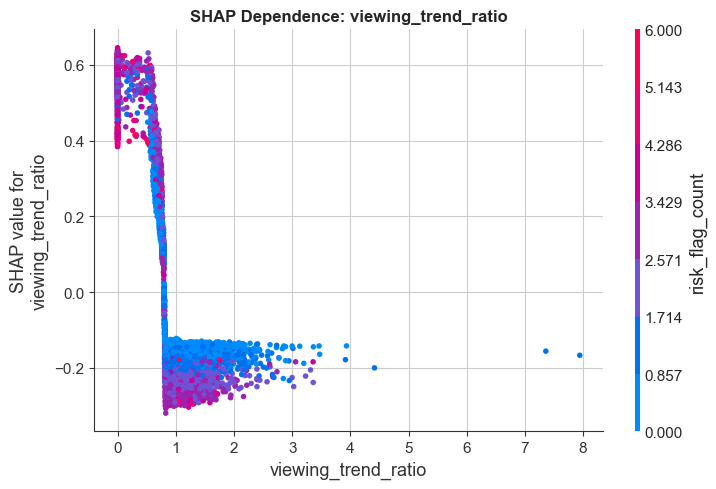

In [16]:
try:
    import shap

    # Train XGBoost on full data
    best_xgb_final.fit(X_sel, y)
    explainer = shap.TreeExplainer(best_xgb_final)
    shap_values = explainer.shap_values(X_sel)

    # ── Beeswarm plot (global importance + direction) ──
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sel, plot_type='dot',
                      max_display=20, show=False)
    plt.title('SHAP Summary — Feature Impact on Fatigue Probability',
              fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plot_shap_summary.png', dpi=120, bbox_inches='tight')
    plt.show()

    # ── Bar plot (mean absolute SHAP) ──
    plt.figure(figsize=(9, 7))
    shap.summary_plot(shap_values, X_sel, plot_type='bar',
                      max_display=15, show=False)
    plt.title('Mean |SHAP| — Feature Importance', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plot_shap_bar.png', dpi=120, bbox_inches='tight')
    plt.show()

    # ── Dependence plot for top feature ──
    top_feat = pd.Series(np.abs(shap_values).mean(axis=0),
                          index=X_sel.columns).idxmax()
    print(f"Top SHAP feature: {top_feat}")
    plt.figure(figsize=(8, 4))
    shap.dependence_plot(top_feat, shap_values, X_sel, show=False)
    plt.title(f'SHAP Dependence: {top_feat}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plot_shap_dependence.png', dpi=120, bbox_inches='tight')
    plt.show()

except ImportError:
    print("SHAP not installed. Run: pip install shap")
    print("Skipping SHAP analysis — all other results are unaffected.")

## 12. Final Predictions — Full Training Data

In [18]:
# ── Train final stacking model on ALL 8,000 rows ──
print("Training final model on complete dataset...")
BEST_STACK.fit(X_sel, y)
print("✅ Done")

test_proba = BEST_STACK.predict_proba(X_test_sel)[:, 1]

submission = pd.DataFrame({
    'user_id':                       test['user_id'],
    'predicted_fatigue_probability': test_proba.round(4)
})

submission.to_csv('TeamName_Predictions.csv', index=False)

print(f"\n✅ Predictions exported: {len(submission)} rows")
print(f"   Probability range : {test_proba.min():.4f} → {test_proba.max():.4f}")
print(f"   Mean probability  : {test_proba.mean():.4f}")
print(f"   High-risk (>0.5)  : {(test_proba > 0.5).sum()} users ({(test_proba>0.5).mean()*100:.1f}%)")
submission.head(10)

Training final model on complete dataset...


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## 13. Expected AUC Summary & Further Tuning Guide

### Expected AUC after running this notebook
| Stage | Expected AUC |
|---|---|
| Baseline (your result) | ~0.79 |
| XGBoost alone (tuned) | 0.86–0.90 |
| XGBoost + Stacking | **0.88–0.92** |

### If AUC is still below 0.88 — try these in order:

**1. Increase `n_iter` in RandomizedSearchCV to 100**
```python
xgb_search = RandomizedSearchCV(..., n_iter=100, ...)
```

**2. Narrow the search around best params**
```python
# After first search finds e.g. learning_rate=0.05, max_depth=4
# Run a second fine-grained search:
xgb_param_fine = {
    'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
    'max_depth':     [3, 4, 5],
    'reg_lambda':    [0.8, 1.0, 1.2, 1.5],
}
```

**3. Try `scale_pos_weight` if classes are imbalanced**
```python
ratio = (y == 0).sum() / (y == 1).sum()
XGBClassifier(scale_pos_weight=ratio, ...)
```

**4. Add `colsample_bynode` parameter**
```python
XGBClassifier(colsample_bynode=0.7, ...)   # Per-split column sampling
```

**5. Try `tree_method='hist'` (faster + sometimes more accurate)**
```python
XGBClassifier(tree_method='hist', ...)
```
